In [1]:
import pandas as pd
import torch

from datasets import load_dataset
import evaluate
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import DataLoader
import torch
from torch import nn
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import sys
sys.path.append("../")

In [5]:
original_df = pd.read_csv('../data/sample.csv')

In [18]:
original_df.iloc[490]

class    bill
text      NaN
Name: 490, dtype: object

In [19]:
original_df["class"].value_counts()

class
proxy             71
contract          70
act               69
application       61
order             50
invoice           43
bill              42
arrangement       40
contract offer    25
statute           21
determination     10
Name: count, dtype: int64

In [23]:
original_df.rename(columns={"class": "labels"}, inplace=True)
# tmp = original_df["text"].apply(lambda x: len(x) if type(x) is str else 0)
# tmp[tmp == 0]

In [24]:
df = original_df.copy()

In [30]:
# df.to_csv("../data/multiclass.csv", index=False)

In [25]:
class_weights = (1 - (df['labels'].value_counts().sort_index() / len(df))).values
class_weights

array([0.8625498 , 0.87848606, 0.92031873, 0.91633466, 0.86055777,
       0.9501992 , 0.98007968, 0.91434263, 0.90039841, 0.85856574,
       0.95816733])

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class_weights = torch.from_numpy(class_weights).float().to(device)
class_weights

tensor([0.8625, 0.8785, 0.9203, 0.9163, 0.8606, 0.9502, 0.9801, 0.9143, 0.9004,
        0.8586, 0.9582], device='cuda:0')

In [27]:
def get_dataset(csv_path, test_size=0.2):
    full_dataset = load_dataset('csv', data_files=csv_path)
    full_dataset = full_dataset.filter(lambda example: example['text'] is not None and example['labels'] is not None)
    full_dataset = full_dataset.class_encode_column("labels")
    dataset = full_dataset['train'].train_test_split(test_size=test_size, stratify_by_column='labels')
    return dataset

In [31]:
dataset = get_dataset("../data/multiclass.csv")

Generating train split: 0 examples [00:00, ? examples/s]

Filter:   0%|          | 0/502 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/501 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/501 [00:00<?, ? examples/s]

In [32]:
labels = sorted(df['labels'].value_counts().keys())  # .sort_index()

In [33]:
id2label = {}
label2id = {}

In [34]:
for i, label in enumerate(labels):
    id2label[i] = label
    label2id[label] = i

In [35]:
pd.Series(dataset['train']['labels']).value_counts()

9     56
4     56
0     55
1     49
8     40
7     34
3     33
2     32
5     20
10    17
6      8
Name: count, dtype: int64

In [36]:
dataset['train'][0]

{'labels': 9,
 'text': 'Д О В Е Р Е Н Н О С Т Ь\nг. Марс\nПервого января две тысячи тринадцатого года\n\nЯ, гражданка России Артемьева Екатерина Григорьевна, 20.12.1982  г.р., пол женский, место рождения:Калуга, загранпаспорт 00№0000000, выдан кем дд.мм.гггг, (если имеется внутренний паспорт) паспорт 0130 000000, выдан НЕ ГУ МВД  29.02.2017, код подразделения 020-030, (для прописанных в России) зарегистрированная: г. Калуга, ул. Лесная д.9, \nдоверяю гражданину России Артемьеву Григорию Михайловичу 28.05.1954 г.р., пол мужской, место рождения: г. Калуга, ул. Лесная д.9, паспорт 12 00 665000, выдан НЕ ГУ МВД 03.06.1996, код подразделения 200-300, зарегистрированному в России по адресу:  г. Калуга, ул. Лесная д.9,\nпредставлять мои интересы во всех государственных административных, правоохранительных и судебных органах Российской Федерации, в том числе в межмуниципальных (районных) народных судах Москвы и Московской области, в Арбитражном суде города Москвы, в Московском городском суде, 

In [37]:
model_name = "distilbert/distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [38]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [39]:
tokenized_dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/101 [00:00<?, ? examples/s]

In [40]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [41]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(labels), id2label=id2label, label2id=label2id)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [42]:
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [43]:
from transformers import AdamW, get_scheduler

dataset_len = (dataset['train'].num_rows + dataset['test'].num_rows)

optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 3
num_training_steps = num_epochs * dataset_len


lr_scheduler = get_scheduler(
    "cosine",
    optimizer=optimizer,
    num_warmup_steps= int(0.1 * num_epochs * dataset_len),
    num_training_steps=num_training_steps
)

/nfs/home/rsim/anaconda3/lib/python3.11/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [44]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        
        outputs = model(**inputs)
        logits = outputs.get('logits')
        
        loss_fct = nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        
        return (loss, outputs) if return_outputs else loss

In [45]:
f1_metric = evaluate.load('f1')

training_args = TrainingArguments(
    output_dir="./results/multiclass-distilbert2/",
    num_train_epochs=50,
    per_device_train_batch_size=24,
    per_device_eval_batch_size=24,
    warmup_steps=200,
    weight_decay=0.01,
    logging_strategy='no',
    evaluation_strategy="steps",
    eval_steps=50,
    save_only_model=True,
    save_strategy="steps",
    save_steps=50,
    save_total_limit=2,
    metric_for_best_model='f1',
    greater_is_better=True,
    eval_accumulation_steps=32,
    fp16=True,  # mixed precision
    load_best_model_at_end = True,
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return f1_metric.compute(predictions=predictions, references=labels, average='macro')

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
    optimizers=[optimizer, lr_scheduler],
)

In [46]:
trainer.train()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: aaromaaa89 (roman02s). Use `wandb login --relogin` to force relogin


/nfs/home/rsim/anaconda3/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,F1
50,No log,2.192146,0.150677
100,No log,1.206110,0.552543
150,No log,0.467366,0.899650


/nfs/home/rsim/anaconda3/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/nfs/home/rsim/anaconda3/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


TrainOutput(global_step=150, training_loss=1.636244405110677, metrics={'train_runtime': 86.9317, 'train_samples_per_second': 230.066, 'train_steps_per_second': 1.725, 'total_flos': 2649773199360000.0, 'train_loss': 1.636244405110677, 'epoch': 50.0})

In [47]:
from tqdm import tqdm


y_pred = []
y_true = tokenized_dataset["test"]['labels']
with torch.no_grad():
    for i in tqdm(range(len(tokenized_dataset["test"]))):
        logits = model(**tokenizer(tokenized_dataset["test"][i]['text'], max_length=512, truncation=True, return_tensors="pt").to(device))
    
        predicted_class_id = logits.logits.argmax().item()
        # model.config.id2label[predicted_class_id]
    
        y_pred.append(predicted_class_id)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:01<00:00, 92.31it/s]


In [48]:
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report

f1_score(y_true, y_pred, average='macro')

0.899650095046614

In [49]:
recall_score(y_true, y_pred, average='macro')

0.8861111111111111

In [50]:
precision_score(y_true, y_pred, average='macro')

0.9430110442142527

In [51]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.97        14
           1       0.92      1.00      0.96        12
           2       0.88      0.88      0.88         8
           3       1.00      1.00      1.00         8
           4       0.82      1.00      0.90        14
           5       1.00      0.40      0.57         5
           6       1.00      1.00      1.00         2
           7       1.00      0.89      0.94         9
           8       0.82      0.90      0.86        10
           9       1.00      0.93      0.97        15
          10       1.00      0.75      0.86         4

    accuracy                           0.92       101
   macro avg       0.94      0.89      0.90       101
weighted avg       0.93      0.92      0.92       101



In [38]:
eval_loss_history = []
eval_f1_history = []
steps = []
for obj in trainer.state.log_history:
    eval_loss_history.append(obj.get('eval_loss'))
    steps.append(obj.get('step'))
    eval_f1_history.append(obj.get('eval_f1'))

In [39]:
eval_loss_history = eval_loss_history[:-1]
eval_f1_history = eval_f1_history[:-1]
steps = steps[:-1]

<Axes: >

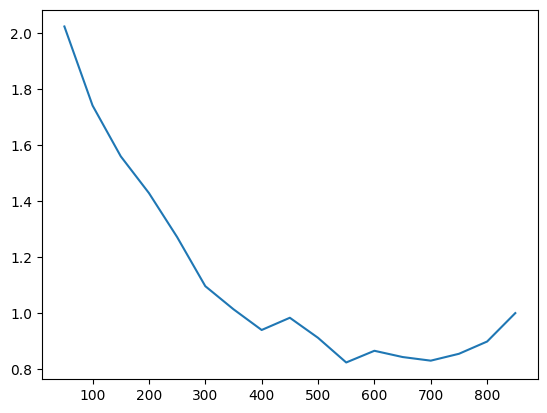

In [40]:
sns.lineplot(x=steps[:len(steps)//4], y=eval_loss_history[:len(eval_loss_history)//4])

<Axes: >

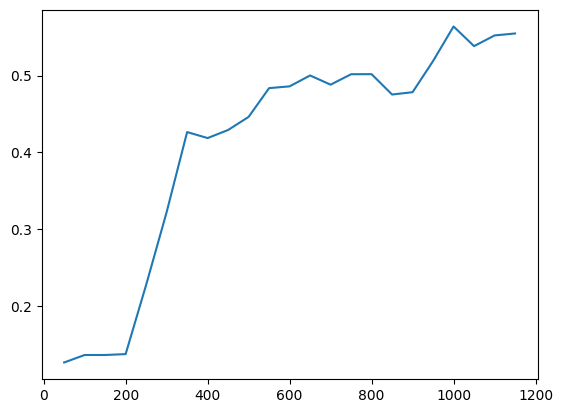

In [41]:
sns.lineplot(x=steps[:len(steps)//3], y=eval_f1_history[:len(steps)//3])